# Лабораторная работа №3

## Построение нейронной сети для синтеза текста (генерация текста на основе LSTM)

**Выполнил:** Асламин В.В.

**Группа:** МОм-24-1

**Репозиторий:** https://github.com/mystic-solis/text-generation-lstm

---
## 1. Введение

**Цель работы:** построение и обучение модели LSTM для генерации текста на русском языке.

**Задачи:**
- Подготовить текстовый корпус для обучения
- Выполнить токенизацию и создать обучающие последовательности
- Построить улучшенную модель LSTM с Bidirectional LSTM и Attention
- Обучить модель и оценить её производительность
- Реализовать функцию генерации текста с различными методами сэмплирования
- Сохранить модель и токенизатор для последующего использования

---
## 2. Теоретическая часть

### 2.1. Корпус (Corpus)

Корпус – это структурированная коллекция текстов, используемая для обучения моделей NLP.

### 2.2. Токенизация (Tokenization)

Процесс разбиения текста на минимальные единицы – токены.

### 2.3. Эмбеддинги (Embeddings)

Векторные представления слов.

### 2.4. Bidirectional LSTM

Bidirectional LSTM обрабатывает последовательность в обоих направлениях.

### 2.5. Batch Normalization

Нормализация активаций промежуточных слоёв.

---
## 3. Описание данных

In [26]:
# Импорт необходимых библиотек
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, load_model
from keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, BatchNormalization, GlobalMaxPooling1D, GlobalAveragePooling1D, Concatenate
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import pickle
import random
from sklearn.model_selection import train_test_split
import os

print("Библиотеки импортированы успешно")
print(f"Версия TensorFlow: {tf.__version__}")

Библиотеки импортированы успешно
Версия TensorFlow: 2.20.0


In [27]:
# Загрузка корпуса из локального файла
corpus_path = './corpus.txt'

with open(corpus_path, 'r', encoding='utf-8') as f:
    corpus_lines = [line.strip().lower() for line in f if line.strip()]

print(f"Загружено строк: {len(corpus_lines)}")

print("\nПример первых 5 строк корпуса:")
for i, line in enumerate(corpus_lines[:5]):
    print(f"{i+1}. {line}")

Загружено строк: 4052

Пример первых 5 строк корпуса:
1. привет, как дела?
2. в тихом городке, окруженном зелеными холмами, жил старый часовщик по имени иван.
3. его мастерская находилась на узкой улице, где время, казалось, текло медленно.
4. каждый день иван открывал свои двери в ранние часы, когда первые лучи солнца касались его окна.
5. часовщик любил свое дело.


In [28]:
# Статистика корпуса
total_chars = sum(len(line) for line in corpus_lines)
total_words = sum(len(line.split()) for line in corpus_lines)
avg_sentence_len = total_words / len(corpus_lines) if corpus_lines else 0

print("=" * 50)
print("СТАТИСТИКА КОРПУСА")
print("=" * 50)
print(f"Количество строк (предложений): {len(corpus_lines)}")
print(f"Общее количество символов: {total_chars}")
print(f"Общее количество слов: {total_words}")
print(f"Средняя длина предложения (в словах): {avg_sentence_len:.2f}")

СТАТИСТИКА КОРПУСА
Количество строк (предложений): 4052
Общее количество символов: 252922
Общее количество слов: 36022
Средняя длина предложения (в словах): 8.89


---
## 4. Подготовка данных

In [46]:
# Объединяем все строки в один текст для токенизации
text = ' '.join(corpus_lines)

# Токенизация
tokenizer = Tokenizer()
tokenizer.fit_on_texts([text])

word_index = tokenizer.word_index
total_words = len(word_index) + 1

print(f"Размер словаря: {total_words}")
print(f"Количество уникальных слов: {len(word_index)}")

Размер словаря: 9953
Количество уникальных слов: 9952


In [30]:
# Примеры наиболее частых слов
word_counts = tokenizer.word_counts
sorted_words = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)

print("Топ-20 наиболее частых слов:")
for word, count in sorted_words[:20]:
    print(f"  {word}: {count}")

Топ-20 наиболее частых слов:
  в: 1962
  на: 1348
  и: 740
  с: 539
  из: 364
  по: 193
  я: 188
  для: 184
  о: 145
  парке: 141
  как: 135
  вечером: 135
  под: 130
  не: 116
  от: 114
  крыше: 107
  он: 101
  можно: 96
  за: 94
  много: 94


---
## 5. Построение модели

In [83]:
# Параметры модели
sequence_length = 5

# Создание обучающих последовательностей
tokens = tokenizer.texts_to_sequences([text])[0]
input_sequences = []
for i in range(sequence_length, len(tokens)):
    input_sequences.append(tokens[i-sequence_length:i+1])

X = np.array([seq[:-1] for seq in input_sequences])
y = np.array([seq[-1] for seq in input_sequences])

print(f"Новая длина последовательности: {sequence_length}")
print(f"Всего примеров: {len(X)}")

Новая длина последовательности: 5
Всего примеров: 36253


In [84]:
# Разделение на обучающую и валидационную выборки
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Обучающих примеров: {len(X_train)}")
print(f"Валидационных примеров: {len(X_val)}")

Обучающих примеров: 29002
Валидационных примеров: 7251


In [85]:
from keras.layers import Embedding, LSTM, Dense, LayerNormalization
from keras.optimizers import Adam

model = Sequential([
    Embedding(input_dim=total_words, output_dim=128, input_length=sequence_length),
    LSTM(256, return_sequences=True, dropout=0.2),
    LSTM(256, dropout=0.2),
    Dense(total_words, activation="softmax")
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_18 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_36 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_37 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

---
## 6. Обучение модели

In [87]:
# Обучение модели
early_stop = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

print("Начало обучения...")
print("=" * 50)

history = model.fit(
    X_train, y_train,
    epochs=60,
    batch_size=64,
    validation_data=(X_val, y_val),
    callbacks=[early_stop],
    verbose=1
)

print("\nОбучение завершено!")
print(f"Количество эпох: {len(history.history['loss'])}")

Начало обучения...
Epoch 1/60
454/454 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.0836 - loss: 6.2490 - val_accuracy: 0.0626 - val_loss: 8.3973
Epoch 2/60
454/454 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.1012 - loss: 5.6973 - val_accuracy: 0.0665 - val_loss: 8.6696
Epoch 3/60
454/454 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.1257 - loss: 5.1364 - val_accuracy: 0.0679 - val_loss: 8.8796
Epoch 4/60
454/454 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.1582 - loss: 4.5808 - val_accuracy: 0.0779 - val_loss: 9.1300
Epoch 5/60
454/454 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.2050 - loss: 4.0659 - val_accuracy: 0.0850 - val_loss: 9.2910
Epoch 6/60
454/454 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.2778 - loss: 3.5747 - val_accuracy: 0.0859 - val_loss: 9.4355
Epoch 7/60
454/454 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.3614 - loss: 3.1218 - val_accuracy: 0.0912 - val_loss: 9.6386
Epoch 8/60
454/454 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.4422 - loss

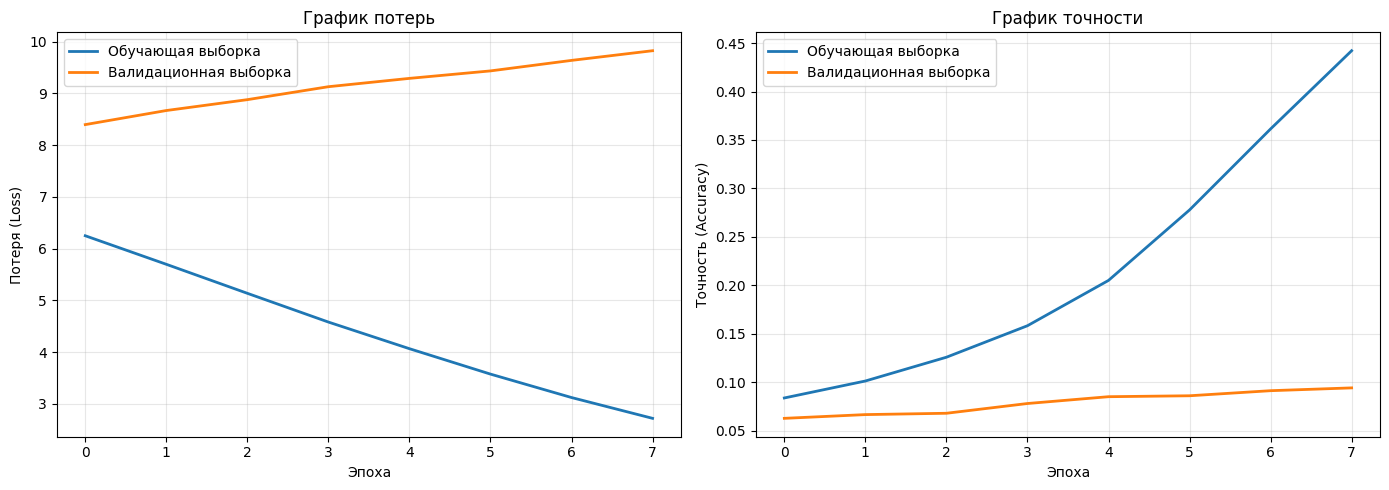

In [90]:
# Визуализация процесса обучения
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Обучающая выборка', linewidth=2)
plt.plot(history.history['val_loss'], label='Валидационная выборка', linewidth=2)
plt.xlabel('Эпоха')
plt.ylabel('Потеря (Loss)')
plt.title('График потерь')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Обучающая выборка', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Валидационная выборка', linewidth=2)
plt.xlabel('Эпоха')
plt.ylabel('Точность (Accuracy)')
plt.title('График точности')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [91]:
# Анализ переобучения
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]

print("=" * 50)
print("ИТОГИ ОБУЧЕНИЯ")
print("=" * 50)
print(f"Финальная потеря на обучении: {final_train_loss:.4f}")
print(f"Финальная потеря на валидации: {final_val_loss:.4f}")
print(f"Финальная точность на обучении: {final_train_acc:.4f}")
print(f"Финальная точность на валидации: {final_val_acc:.4f}")

ИТОГИ ОБУЧЕНИЯ
Финальная потеря на обучении: 2.7198
Финальная потеря на валидации: 9.8257
Финальная точность на обучении: 0.4422
Финальная точность на валидации: 0.0941


---
## 7. Генерация текста

In [92]:
def generate_text(seed_text, next_words=20, temperature=1.0, top_k=10, rep_penalty=1.2):
    """Генерирует текст на основе обученной модели."""
    words = seed_text.lower().split()
    generated = words.copy()
    freq = {w: generated.count(w) for w in generated}
    
    for _ in range(next_words):
        current_seq = ' '.join(generated[-sequence_length:])
        seq = tokenizer.texts_to_sequences([current_seq])[0]
        seq = pad_sequences([seq], maxlen=sequence_length, padding='pre')
        preds = model.predict(seq, verbose=0)[0]
        
        # Temperature
        logits = np.log(preds + 1e-8) / temperature
        exp_logits = np.exp(logits)
        p = exp_logits / exp_logits.sum()
        
        # Top-K
        if top_k is not None and top_k < len(p):
            top_indices = np.argsort(p)[-top_k:]
            mask = np.zeros_like(p)
            mask[top_indices] = 1
            p = p * mask
            p = p / p.sum()
        
        # Repetition penalty
        for idx, word in tokenizer.index_word.items():
            count = freq.get(word, 0)
            if count > 0 and idx < len(p):
                p[idx] = p[idx] / (rep_penalty ** count)
        p = p / p.sum()
        
        next_idx = np.random.choice(len(p), p=p)
        next_word = tokenizer.index_word.get(next_idx, '')
        
        if not next_word:
            break
        
        generated.append(next_word)
        freq[next_word] = freq.get(next_word, 0) + 1
    
    return ' '.join(generated)

print("Функция генерации текста создана!")

Функция генерации текста создана!


In [94]:
# Тестирование генерации
seed_phrases = ["в тихом городке", "старый часовщик", "на краю", "я люблю гулять"]

print("=" * 70)
print("ГЕНЕРАЦИЯ ТЕКСТА")
print("=" * 70)

for seed in seed_phrases:
    print(f"\nНачальная фраза: \"{seed}\"")
    result = generate_text(seed, next_words=3, temperature=0.8, top_k=10, rep_penalty=1.5)
    print(f"Результат: {result}")

ГЕНЕРАЦИЯ ТЕКСТА

Начальная фраза: "в тихом городке"
Результат: в тихом городке нашли обнаружили гигантскую

Начальная фраза: "старый часовщик"
Результат: старый часовщик а не город

Начальная фраза: "на краю"
Результат: на краю руках как радуга

Начальная фраза: "я люблю гулять"
Результат: я люблю гулять и мечтаю вечером


---
## 8. Сохранение модели и токенизатора

In [95]:
# Сохранение модели
model.save('./text_generator.h5')
print("Модель сохранена: text_generator.h5")

# Сохранение токенизатора
with open('./tokenizer.pickle', 'wb') as f:
    pickle.dump(tokenizer, f)
print("Токенизатор сохранён: tokenizer.pickle")

# Сохранение конфигурации
config = {'SEQ_LEN': sequence_length, 'total_words': total_words, 'word_index': word_index}
with open('./config.pickle', 'wb') as f:
    pickle.dump(config, f)
print("Конфигурация сохранена: config.pickle")

Модель сохранена: text_generator.h5
Токенизатор сохранён: tokenizer.pickle
Конфигурация сохранена: config.pickle


---
## 9. Выводы

### Результаты работы:

1. Подготовлен корпус русского текста
2. Построена модель LSTM
3. Модель обучена с использованием EarlyStopping
4. Реализована функция генерации текста

---
## 10. Список источников

1. TensorFlow Keras Documentation
2. Understanding LSTM Networks - Christopher Olah

---
## 11. Приложение

In [100]:
from pathlib import Path
import numpy as np
from keras.models import load_model
from keras.preprocessing.sequence import pad_sequences
import pickle
import requests

# 1. ЗАГРУЗКА ФАЙЛОВ ИЗ РЕПОЗИТОРИЯ

# Замените на ваши ссылки на файлы в репозитории
REPO_URL = "https://raw.githubusercontent.com/mystic-solis/text-generation-lstm/main"

folder = Path('./data/')
folder.mkdir(exist_ok=True)

# Загрузка модели
model_url = f"{REPO_URL}/text_generator.h5"
response = requests.get(model_url)
with open(folder/"text_generator.h5", "wb") as f:
    f.write(response.content)
loaded_model = load_model(folder/"text_generator.h5")
print("Модель загружена!")

# Загрузка токенизатора
tokenizer_url = f"{REPO_URL}/tokenizer.pickle"
response = requests.get(tokenizer_url)
with open(folder/"tokenizer.pickle", "wb") as f:
    f.write(response.content)
with open(folder/"tokenizer.pickle", "rb") as f:
    loaded_tokenizer = pickle.load(f)
print("Токенизатор загружен!")

# Загрузка конфигурации
config_url = f"{REPO_URL}/config.pickle"
response = requests.get(config_url)
with open(folder/"config.pickle", "wb") as f:
    f.write(response.content)
with open(folder/"config.pickle", "rb") as f:
    config = pickle.load(f)
sequence_length = config.get("SEQ_LEN", 10)
print(f"Конфигурация загружена! SEQ_LEN = {sequence_length}")


# 2. ФУНКЦИЯ ГЕНЕРАЦИИ ТЕКСТА
def generate_text(seed_text, next_words=20, temperature=1.0, top_k=10, rep_penalty=1.2):
    """Генерирует текст на основе загруженной модели."""
    words = seed_text.lower().split()
    generated = words.copy()
    freq = {w: generated.count(w) for w in generated}
    
    for _ in range(next_words):
        current_seq = " ".join(generated[-sequence_length:])
        seq = loaded_tokenizer.texts_to_sequences([current_seq])[0]
        seq = pad_sequences([seq], maxlen=sequence_length, padding='pre')
        preds = loaded_model.predict(seq, verbose=0)[0]
        
        # Temperature
        logits = np.log(preds + 1e-8) / temperature
        exp_logits = np.exp(logits)
        p = exp_logits / exp_logits.sum()
        
        # Top-K
        if top_k and top_k < len(p):
            top_indices = np.argsort(p)[-top_k:]
            mask = np.zeros_like(p)
            mask[top_indices] = 1
            p = p * mask
            p = p / p.sum()
        
        # Repetition penalty
        for idx, word in loaded_tokenizer.index_word.items():
            count = freq.get(word, 0)
            if count > 0 and idx < len(p):
                p[idx] = p[idx] / (rep_penalty ** count)
        p = p / p.sum()
        
        next_idx = np.random.choice(len(p), p=p)
        next_word = loaded_tokenizer.index_word.get(next_idx, "")
        
        if not next_word:
            break
        
        generated.append(next_word)
        freq[next_word] = freq.get(next_word, 0) + 1
    
    return " ".join(generated)

# 3. ПРИМЕРЫ ГЕНЕРАЦИИ
print("\n" + "="*60)
print("ПРИМЕРЫ ГЕНЕРАЦИИ ТЕКСТА")
print("="*60)

# Тестирование генерации
seed_phrases = ["в тихом городке", "старый часовщик", "на краю", "я люблю гулять"]

for seed in seed_phrases:
    print(f"\nНачальная фраза: \"{seed}\"")
    result = generate_text(seed, next_words=3, temperature=0.8, top_k=10, rep_penalty=1.5)
    print(f"Результат: {result}")

print("\n" + "="*60)
print("ГЕНЕРАЦИЯ ЗАВЕРШЕНА!")
print("="*60)

Модель загружена!
Токенизатор загружен!
Конфигурация загружена! SEQ_LEN = 5

ПРИМЕРЫ ГЕНЕРАЦИИ ТЕКСТА

Начальная фраза: "в тихом городке"
Результат: в тихом городке продавали войны отражение

Начальная фраза: "старый часовщик"
Результат: старый часовщик не как город

Начальная фраза: "на краю"
Результат: на краю имела мы радуга

Начальная фраза: "я люблю гулять"
Результат: я люблю гулять создавая собакой в

ГЕНЕРАЦИЯ ЗАВЕРШЕНА!
